# 1. Purpose
This notebook is a testing ground for a human-robot chatbox interface. There are three primary elements to our intelligent chatbox:
 * **Suggestions** using [Bootstrap-3 Typeahead](https://github.com/bassjobsen/Bootstrap-3-Typeahead), so that the user has a better understanding of the language the robot can understand.
 * **Template-matching** to allow the robot to understand non-standard sentences. We're building off Tellex, Kollar and others' work on Spatial Description Clauses [1,2] to parse the natural language into our templates.
 * **Online correction**, in which the operator tells the robot that the robot misunderstood.


## Template-matching model
<img src="Chatbox Workflow.png" width="600">

# 2. Basic Chatbox with Autocomplete

In [2]:
%%javascript

requirejs(['bootstrap.min.js', 'bootstrap3-typeahead.min.js'], function(){});

<IPython.core.display.Javascript object>

<div classr="row" style="height:175px;">
    <div class="col-md-12">
        <!-- Chat Box -->
        <div class="input-group col-md-8">
          <input id="chatInput" type="text" data-provide="typeahead" autocomplete="off" class="form-control" placeholder="I think Roy is near the Kitchen.">
          <span class="input-group-btn" style="width:10%;">
            <button id="human_chat_button" class="btn btn-danger" type="button">Submit</button>
          </span>
        </div><!-- /input-group -->		
  </div><!-- /.col-lg-12 -->
</div><!-- /.row -->    					


In [1]:
%%javascript

// // Remove space to scroll
// window.onkeydown = function(e) {
//     if(e.keyCode == 32 && e.target == document.body) {
//         e.preventDefault();
//         return false;
//     }
// };

// // Remove all keyboard shortcuts
// var cmd = IPython.keyboard_manager.command_shortcuts;
// cmd.clear_shortcuts()


// // Submit button
// jQuery("#human_chat_button").unbind().click(function() { 
//     var str = jQuery.trim(jQuery("#chatInput").val()) + '.'
//     console.log("You said: " + str);
// });

// //Typeahead
// jQuery.get('typeahead.json', function(data){
//         jQuery("#chatInput").typeahead({ 
//             source:data, 
//             items:'5',
//             matcher: function (item) {
//                 var last = this.query.split(' ');
//                 this.query = jQuery.trim(last[last.length-1]);

//                 if(this.query.length) return ~item.toLowerCase().indexOf(this.query.toLowerCase());
//             },
//             updater: function (item) {
//                 var input = this.$element.val().split(' ');
//                 for (var i=0; i < input.length-1; i++){
//                     word = input[i]
//                     if (item.toLowerCase().indexOf(word.toLowerCase()) > -1){
//                         item = item.replace(word + ' ','')
//                     }
//                 }
//                 return this.$element.val().replace(new RegExp(this.query + '$'),'') + item + ' ';
//             }
//         });
// }, 'json');

<IPython.core.display.Javascript object>

# 3. Conditional Random Fields

Conditional Random Fields (CRFs) are a classification technique postulated by Lafferty et al. [4]. They are similar to Hidden Markov Models (HMMs) and stochastic grammars (SGs), but, unlike those two generative models (i.e. concerned with joint label-observation probability), are a discriminative model (i.e. concerned with label probability conditioned on observations). SGs and HMMs can be intractable because of their need to enumerate all possible observation sequences; this is not the case for CRFs.

Other discriminative models, such as Maximum Entropy Markov Models (MEMMs), however, suffer from the label-bias problem, in which the transition probabilities leaving any one state only interact with other transitions leaving that state, rather than the global transition set. This causes a bias towards states with fewer outgoing transitions (as illustrated in [4]). CRFs don't have this problem, as Lafferty et al. states: "The critical difference between CRFs and MEMMs is that a MEMM uses per-state exponential models for the conditional probabilities of next states given the current state, while a CRF has a single exponential model for the joint probability of the entire sequence of labels given the observation sequence."

In essence, we want to learn $p(\mathbf{Y} \vert \mathbf{X})$, where $\mathbf{Y}$ is a sequence of labels given to the sequence of observed values $\mathbf{X}$. Once we've trained our model, we can find the $\mathbf{Y_*}$ that maximizes $p(\mathbf{Y_*} \vert \mathbf{X_*})$, where a $*$ signifies a new sequence.

By the Hammersley-Clifford theorem of random fields, the join distribution over $\mathbf{Y}$, given $\mathbf{X}$, is:

$$
p_\theta(\mathbf{y} \vert \mathbf{x}) \propto \exp\left( 
\sum_{e \in E,k} \lambda_k f_k(e,\mathbf{y}\vert_e,\mathbf{x}) +
\sum_{v \in V,k} \mu_k g_k(v,\mathbf{y}\vert_v,\mathbf{x})
\right)
$$

where $f_k(\cdot)$ and $g_k(\cdot)$ are *transition feature functions* and *state feature functions*, respectively, that are defined a priori, and $\lambda_k$, $\mu_k$ are parameters to be learned from training data.


In [10]:
from __future__ import division
%load_ext autoreload
%autoreload 2

from cops_and_robots.fusion.tdc import TDC, TDC_Collection, generate_fleming_test_data, generate_test_data
import logging
logging.getLogger().setLevel(logging.INFO)

# Training and test data
training_data = generate_fleming_test_data()
test_data = generate_test_data()

test_data = [(t[0], '') for t in test_data]
print test_data

# Save to a file
# training_data = data[:len(data)//2]
# test_data = data[len(data)//2:]
with open('training.data','w') as file_:
    for d in training_data:
        str_ = '\t'.join(d) + '\n'
        str_ = str_.replace (" ", "_")
        file_.write(str_)
with open('test.data','w') as file_:
    for d in test_data:
        str_ = '\t'.join(d) + '\n'
        str_ = str_.replace (" ", "_")
        file_.write(str_)
        
        
import textwrap
# Create Template
def create_template(model_i=1):
    model0 = """
               # Unigram
               U00:%x[-2,0]
               U01:%x[-1,0]
               U02:%x[0,0]
               U03:%x[1,0]
               U04:%x[2,0]
               U05:%x[-1,0]/%x[0,0]
               U06:%x[0,0]/%x[1,0]
               
               # Bigram
               B"""

    model1 = """
               # Unigram
               U00:%x[-2,0]
               U01:%x[-1,0]
               U02:%x[0,0]
               U03:%x[1,0]
               U04:%x[2,0]
               U05:%x[-1,0]/%x[0,0]
               U06:%x[0,0]/%x[1,0]
                              
               # Bigram
               B"""
    models = [model0, model1]
    template = models[model_i]
  
    with open('template','w') as file_:
        file_.write(textwrap.dedent(template))
create_template()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[('Roy', ''), ('is', ''), ('moving', ''), ('North', ''), ('.', ''), ('That robot', ''), ('is', ''), ('stopped', ''), ('.', ''), ('Nothing', ''), ('is', ''), ('next to', ''), ('the dresser', ''), ('.', ''), ('I', ''), ("don't", ''), ('see', ''), ('anything', ''), ('near', ''), ('the desk', ''), ('.', ''), ('I think', ''), ('a robot', ''), ('is', ''), ('in', ''), ('the kitchen', ''), ('.', ''), ('Pris', ''), ('is', ''), ('moving', ''), ('really quickly', ''), ('.', ''), ('The green one', ''), ('is', ''), ('heading', ''), ('over there', ''), ('.', ''), ('The red guy', ''), ('is', ''), ('spinning around', ''), ('the table', ''), ('.', ''), ("A robot's", ''), ('moving', ''), ('away from', ''), ('you', ''), ('.', ''), ("There's", ''), ('another robot', ''), ('heading', ''), ('towards', ''), ('you', ''), ('.', ''), ("He's", ''), ('running', ''), ('away from', ''), ('you', ''), ('!', ''), ("He's", ''), ('be

In [11]:
%%bash
crf_learn template training.data trained_model
crf_test -m trained_model -v1 test.data > output.data

CRF++: Yet Another CRF Tool Kit
Copyright (C) 2005-2013 Taku Kudo, All rights reserved.

reading training data: 
Done!0.03 s

Number of sentences: 1
Number of features:  3696
Number of thread(s): 8
Freq:                1
eta:                 0.00010
C:                   1.00000
shrinking size:      20
iter=0 terr=0.90400 serr=1.00000 act=3696 obj=19459.10149 diff=1.00000
iter=1 terr=0.01590 serr=1.00000 act=3696 obj=13170.15769 diff=0.32319
iter=2 terr=0.01600 serr=1.00000 act=3696 obj=577.34690 diff=0.95616
iter=3 terr=0.00010 serr=1.00000 act=3696 obj=312.76366 diff=0.45827
iter=4 terr=0.00010 serr=1.00000 act=3696 obj=199.71153 diff=0.36146
iter=5 terr=0.00010 serr=1.00000 act=3696 obj=124.66021 diff=0.37580
iter=6 terr=0.00010 serr=1.00000 act=3696 obj=92.37343 diff=0.25900
iter=7 terr=0.00010 serr=1.00000 act=3696 obj=83.09977 diff=0.10039
iter=8 terr=0.00000 serr=0.00000 act=3696 obj=76.91174 diff=0.07447
iter=9 terr=0.00000 serr=0.00000 act=3696 obj=74.51002 diff=0.03123
iter=10

In [12]:
import pandas as pd
from IPython.display import display, HTML

with open('output.data','r') as f:
    output = f.read()
    print output
    strings = output.split('\n')
    results = []
    for str_ in strings:
        result = str_.replace('/','\t').split('\t')
        if len(result) < 3:
            continue
        
        # Replace underscores
        result = [result[0].replace('_',' ')] + result[1:]
        
        # Check correctness
        if result[-3] == result[-2]:
            result += [True]
        else:
            result += [False]
        results.append(result)
        
key_results = [r for r in results if r[0] not in (',','.','!','?')]
        
df = pd.DataFrame(key_results)
# df.columns = ['Token','True Tag','Estimated Tag','Marginal prob.', 'Correctness']
num_correct = sum([1 for r in key_results if r[-1]])
print("{}% correct (excluding punctuation) with {} training examples and {} test examples"
      .format(num_correct/len(key_results) * 100, len(training_data), len(test_data) ))
display(df)

    

# 0.000001
Roy	TARGET/0.920948
is	POSITIVITY/0.982520
moving	ACTION/0.974052
North	MODIFIER/0.963726
.	NULL/0.938102
That_robot	TARGET/0.829912
is	POSITIVITY/0.888594
stopped	ACTION/0.971097
.	NULL/0.956544
Nothing	TARGET/0.732359
is	POSITIVITY/0.790934
next_to	SPATIALRELATION/0.895622
the_dresser	GROUNDING/0.908690
.	NULL/0.903816
I	NULL/0.786335
don't	NULL/0.228961
see	TARGET/0.366949
anything	POSITIVITY/0.553697
near	SPATIALRELATION/0.858165
the_desk	GROUNDING/0.960993
.	NULL/0.966721
I_think	NULL/0.977375
a_robot	TARGET/0.989834
is	POSITIVITY/0.987815
in	SPATIALRELATION/0.973151
the_kitchen	GROUNDING/0.968591
.	NULL/0.989369
Pris	TARGET/0.948670
is	POSITIVITY/0.975988
moving	ACTION/0.973729
really_quickly	MODIFIER/0.963770
.	NULL/0.927362
The_green_one	TARGET/0.744197
is	POSITIVITY/0.803237
heading	SPATIALRELATION/0.909628
over_there	GROUNDING/0.927089
.	NULL/0.971219
The_red_guy	TARGET/0.751947
is	POSITIVITY/0.801642
spinning_around	SPATIALRELATION/0.881109
the_table	GROUNDING/0.8

,0,1,2,3
0,Roy,TARGET,0.920948,False
1,is,POSITIVITY,0.982520,False
2,moving,ACTION,0.974052,False
3,North,MODIFIER,0.963726,False
4,That robot,TARGET,0.829912,False
5,is,POSITIVITY,0.888594,False
6,stopped,ACTION,0.971097,False
7,Nothing,TARGET,0.732359,False
8,is,POSITIVITY,0.790934,False
9,next to,SPATIALRELATION,0.895622,False


## 3.1 Dependency Parsing

In [4]:
import spacy.en
nlp = spacy.en.English()

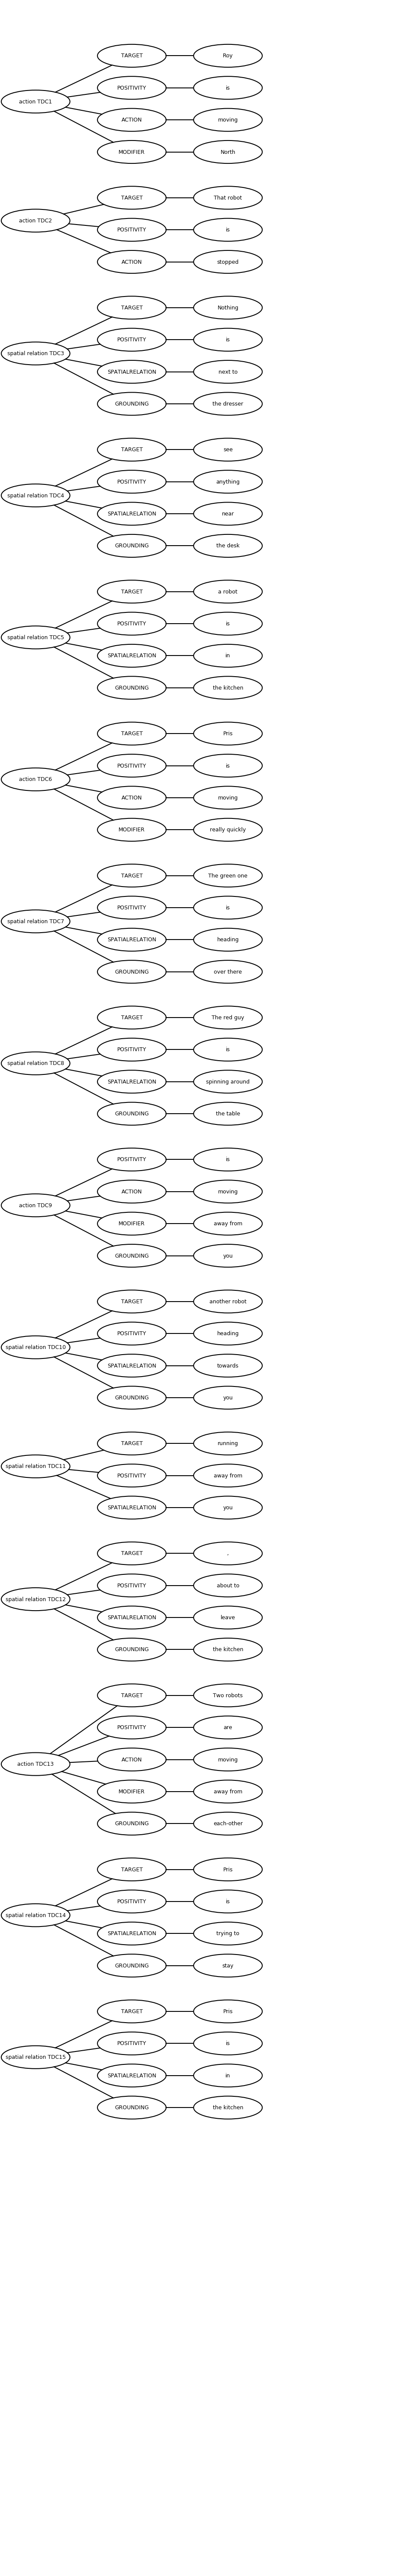

In [5]:
   
true_tagged_document = list(test_data)
tagged_document = [[r[0], r[2]] for r in results]
TDC_collection = TDC_Collection(tagged_document)

TDC_collection.plot_TDCs()
from IPython.display import Image
Image("TDC Graph.png")

## Similarity checking

In [12]:
import numpy as np
templates = ['Desk','Room','front','back','right','fast']

similarities = np.zeros((len(templates), len(key_results)))
for i, t in enumerate(templates):
    for j, result in enumerate(key_results):
        similarities[i,j] = nlp(unicode(t)).similarity(nlp(unicode(result[0].replace('_',' '))))

df_sims = pd.DataFrame(similarities.T)
df_sims.columns = templates
df_sims.index= [r[0].replace('_',' ') for r in key_results]
display(df_sims)


,Desk,Room,front,back,right,fast
Roy,0.222160,0.207482,0.226839,0.240516,0.134723,0.116586
is,0.243208,0.181479,0.177351,0.213465,0.205039,0.218538
moving,0.198178,0.146636,0.212871,0.351911,0.245323,0.300679
North,0.187397,0.198339,0.367533,0.352258,0.328631,0.297084
That robot,0.370133,0.345990,0.250134,0.240104,0.245443,0.269609
is,0.243208,0.181479,0.177351,0.213465,0.205039,0.218538
stopped,0.270893,0.203678,0.143985,0.246237,0.148222,0.221616
Nothing,0.202598,0.249843,0.117106,0.109173,0.218853,0.125717
is,0.243208,0.181479,0.177351,0.213465,0.205039,0.218538
next to,0.334348,0.282128,0.255326,0.373694,0.317644,0.363806


In [45]:
nl_target = nlp(u'Roy')
targets = ['Roy', 'Pris', 'Zhora', 'a robot', 'nothing']
targets = [nlp(unicode(t)) for t in targets]

similarities = np.zeros((len(targets), 1))
for i, target in enumerate(targets):
    similarities[i] = nl_target.similarity(target)

df_sims = pd.DataFrame(similarities.T)
df_sims.columns = [t.string for t in targets]
df_sims.index= ['Roy']
display(df_sims)

nl_ground = nlp(u'leafy plant')
groundings = ['Bookcase', 'Desk', 'Chair', 'Filing Cabinet','Dining Table', 'Mars Poster', 'Cassini Poster',
           'Fridge', 'Checkers Table', 'Fern']
groundings = [nlp(unicode(g.lower())) for g in groundings]

similarities = np.zeros((len(groundings), 1))
for i, grounding in enumerate(groundings):
    similarities[i] = nl_ground.similarity(grounding)

df_sims = pd.DataFrame(similarities.T)
df_sims.columns = [g.string for g in groundings]
df_sims.index= [nl_ground.string]
display(df_sims)


,Roy,Pris,Zhora,a robot,nothing
Roy,1,0,0,0.348365,0.194701


,bookcase,desk,chair,filing cabinet,dining table,mars poster,cassini poster,fridge,checkers table,fern
leafy plant,0.543582,0.306591,0.267159,0.268207,0.437532,0.346457,0.342815,0.506434,0.38132,0.619783


# 4. Spatial Description Clauses

Building off the work of [3], Tellex, Kollar et. al [1,2] created Spatial Description Clauses (SDCs), which contain:
* A **figure**, the subject of the sentence;
* A **verb**, an action to take;
* A **landmark**, an object in the environment;
* A **spatial relation**, a geometric relation between the landmark and the figure.

SDCs are hierarchical, but they make the approximation that hierarchy as a sequence of SDCs. To ensure model tractability, they use a [Conditional Random Field](https://en.wikipedia.org/wiki/Conditional_random_field) (CRF) to extract SDCs from the input text. The CRF labels each word in each sentence with one of four possible fields (figure, verb, landmark, spatial relation) or none. We would use our three (target, grounding, spatial relation) or none. **NOTE: what corpus would we use to train this?**

Similarly, our human sensor model (call it SOC, or spatial observation clause) is based on:
* A **target**, the agent to be found **NOTE: how should we generalize this?**;
* A **grounding**, similar to the landmark **NOTE: should we simply call this a landmark for consistency?**;
* A **spatial relation**, a geometric relation between the landmark and the target.

Essentially, we have reduced the complexity of the statement by not including the **verb** component. There is no imperative -- there is only information.

We give our robots a complete semantic map of the environment (knowing the locations and labels of all groundings, whether they be objects, areas, or themselves). The goal of the cop robot is to find the robber robots, which means we can't use a robber robot as a grounding, unless it is exactly known. **NOTE: Should we investigate non-deterministic groundings?**

## Tellex Formulation
To find the best mapping between input and a plan, Tellex et al. uses :

$$
\DeclareMathOperator*{\argmax}{arg\,max}
\argmax_P p(P,S, \vert O) = p(S \vert P,O) p(P \vert O)
$$

Where $P$ is the path (based on a topological roadmap), $S$ is the CRF-factorized sequence of SDCs provided by the human (i.e. list of directions from the humans factorized into landmarks, verbs, etc.), and $O$ are the detected objects. They model paths as transitions between viewpoints in the environment, $v_i$, and the directions as a list of SDCs. They assume the path is independent of the detected objects, so:

\begin{align*}
p(P,S \vert O) &\approx p(sdc_1, \dots, sdc_M \vert v_1, \dots, v_{M+1}, O)p(v_1, \dots, v_{M+1})\\
&= \left[\sum_{i=1}^M p(sdc_i \vert v_i, v_{i+1}, O)\right] \left[\sum_{i=1}^M p(v_{i+1} \vert v_i \dots, v_1)\right] p(v_1)
\end{align*}

Where,

\begin{align*}
p(sdc_i \vert v_i, v_{i+1}, O) &= p(f_i, a_i, s_i, l_i \vert v_i, v_{i+1}, O) \\
&\approx p(f_i \vert v_i, v_{i+1}, o_1, \dots, o_K) p(a_i \vert v_i, v_{i+1}) p(s_i \vert l_i, v_i, v_{i+1}, o_1, \dots, o_K) p(l_i \vert v_i, v_{i+1}, o_1, \dots, o_K)
\end{align*}

That is, the distribution is now factored into the four parts of an SDC, plus transition probabilities.

## Sweet Formulation
Our model should be:

$$
\argmax_h p(h,sdc \vert o) = p(sdc \vert h, o) p(h \vert o)
$$

Where $h$ is a human sensor statement template, such as "I know Roy is in front of the chair." 

One major difference in the formulations is that ours doesn't maintain any notion of dynamics. Whereas their formulation required a batch estimate by parsing of a collection of SDCs, we require a single estimate generated online as each individual human statement arrives and is parsed into SDC form. This means that $h$, $o$ and $sdc$ are independent of any others from $H$, $O$ and $S$, respectively.

$H$ can be generated from the known relations, targets and groundings in the environment. Note that we have removed the $P$ term because we do not couple planning with sensing. However, $O$ may be considered if we wish to influence $H$ and $S$ by the possible objects the human may be able to reference (i.e., give preference to statements tied to observations the human is able to make given the current context). **NOTE: Tellex's $O$ references the objects the robot is able to observe, but our $o$ references the objects the human is able to observe.** Alternatively, without taking the human context into account, we would consider the simpler case of $\argmax_h p(h,sdc) = p(sdc \vert h) p(h)$.

Expanding the SDC term in $p(sdc \vert h, o)$, we get:

$$
p(sdc \vert h, o) = p(t,g,r \vert h, o) \approx p(t \vert h, o) p(g \vert h, o) p(r \vert h, o)
$$

Where $t$ is a target, $g$ is a grounding, and $r$ is a spatial relation. We approximate $p(t,g,r \vert h, o)$ by assuming independence between the target, grounding and relation (that is, a human would describe any target using any grounding and any spatial relation with uniform probability).

Furthermore, we can decompose a human sensor statement $h$ into a target $t_h$, a grounding $g_h$, and a spatial relation $r_h$. We assume that targets are independent of groundings and spatial relation, groundings are independent of targets and spatial relations, and spatial relations are independent of targets and groundings, to reach:

$$
\begin{split}
p(t \vert h, o) p(g \vert h, o) p(r \vert h, o) &= p(t \vert t_h, g_h, r_h, o) p(g \vert t_h, g_h, r_h, o) p(r \vert t_h, g_h, r_h, o) \\ 
&\approx p(t \vert t_h, o) p(g \vert g_h, r_h, o) p(r \vert g_h, r_h, o)
\end{split}
$$

In short, our goal is to solve the following:

$$
\argmax_h p(t \vert t_h, o) p(g \vert g_h, r_h, o) p(r \vert g_h, r_h, o) p(t_h, g_h, r_h \vert o)
$$

Where we use word2vec to get the co-occurrence of $t$ and $t_h$ (similarly for $g$ and $r$). If these measures are independent of the human's observation space and the joint probability of $p(t_h, g_h, r_h)$ is assumed to be uniform, then we solve the simpler problem of:

$$
\argmax_h p(t \vert t_h) p(g \vert g_h) p(r \vert r_h) = p(w_{O,t} \vert w_{I,t}) p(w_{O,g} \vert w_{I,g}) p(w_{O,r} \vert w_{I,r})
$$

Where $p(w_{O,t} \vert w_{I,t})$ takes the form following equation (2) in [3] as a measure of similarity between input and output words. However, if we include the human observation space, we know that $p(t \vert h, o) = \frac{p(t \vert h) p(t \vert o)}{p(t_h)}$ (following the derivation below). We can conceivably define $p(t \vert o)$ based on human data and we assume that $p(t_h)$ is uniform.

$$
\begin{split}
p(t \vert t_h, o) &= \frac{p(t, t_h, o)}{p(t_h, o)} \\
&= \frac{p(t, t_h, o)}{p(h) p(o)}\\
&= \frac{p(t, t_h \vert o) p(o)}{p(t_h) p(o)} \\
&= \frac{p(t_h \vert t, o) p(t \vert o)}{p(t_h)} \\
&= \frac{p(t_h \vert t) p(t \vert o)}{p(t_h)} \\
\end{split}
$$

### Issues
* We must learn the probability of specifying a non-template target, grounding or spatial relation given the observation space -- $p(t \vert o)$, $p(g \vert o)$, and $p(r \vert o)$. Since $T > T_H$ (that is, the number of ways a human could describe the target is greater than the number of specified template names for the target), we are likely to encounter terminology for which we have not learned $p(t \vert o)$, $p(g \vert o)$, and $p(r \vert o)$.
* The word2vec-provided values $p(t_h \vert t)$, $p(g_h \vert g)$, and $p(r_h \vert r)$ are dependent on the corpus from which the neural net is trained. Corpus selection, thus, heavily influences the responses understood by the system.

### Benefits
* Instead of simply taking $\argmax_h p(t \vert t_h) p(g \vert g_h) p(r \vert r_h)$, we can take  $J = \max_h p(t \vert t_h) p(g \vert g_h) p(r \vert r_h)$ and compare $J$ to a tunable threshold value to determine whether the robot believes it fully understands what the human is asking.

## General Assumptions
* correctness metric based on the question: did the robot correctly rephrase the intended human statement?
* the robot has a known semantic map of the environment, with objects and areas privately labeled.
* temporal information - "is going to move north" vs "is moving north"

# 5. Word2Vec



# 6. References

[1] T. Kollar, S. Tellex, D. Roy, and N. Roy, “Toward understanding natural language directions,” Proceeding 5th ACM/IEEE Int. Conf. Human-robot Interact. - HRI ’10, p. 259, 2010.

[2] S. Tellex, T. Kollar, and S. Dickerson, “Understanding Natural Language Commands for Robotic Navigation and Mobile Manipulation.,” in AAAI Conference on Artificial Intelligence, 2011, pp. 1507–1514.

[3] T. Mikolov, K. Chen, G. Corrado, and J. Dean, “Distributed Representations of Words and Phrases and their Compositionality,” Nips, pp. 1–9, 2013.

[4] J. Lafferty, A. McCallum, and F. C. N. Pereira, “Conditional random fields: Probabilistic models for segmenting and labeling sequence data,” ICML ’01 Proc. Eighteenth Int. Conf. Mach. Learn., vol. 8, no. June, pp. 282–289, 2001.

[5] B. Landau and R. Jackendoff, “‘What’ and ‘Where’ in Spatial Language and Spatial Cognition,” Behav. Brain Sci., vol. 16, pp. 217–265, 1993.

[6] T. Kaupp, A. Makarenko, F. Ramos, B. Upcroft, S. Williams, and H. Durrant-Whyte, “Adaptive human sensor model in sensor networks,” 2005 7th Int. Conf. Inf. Fusion, FUSION, vol. 1, pp. 748–755, 2005.

# 7. Notes
* Chatbox interface options:
  * Post-hoc correction (i.e. "was this correct? yes/no")
  * Suggestions
* Identify confidence of translation
* Calibration
* Identify differences between chat and speech
  * Spelling/typos (include autocorrection?)
  * Abbreviations
* Look into categorizing observations in the same way that Tellex et al. categorized imperative commands
  * Is there a specific clause that captures all observations in the same way that an imperative clause captures all commands?
* Develop human trials - provide recordings of the system in action to viewers, have them describe what's happening in their own words
  * Instead of asking humans to fit a specific structure, discover how humans want to provide information
* Discuss with Martha Palmer? Is there a taxonomy for how people provide observations? 
* Should be able to handle *distances* as well - i.e. "The table is about 30 feet past the fridge."
* Requires a knowledge of the human state. The meaning of "behind a ball" changes based on the observer's location and the robot's location. Is it behind the ball from the robot's perspective, or from the human's? Should both be accounted for?
* Can the chatbox suggest words that make the human a better sensor? Instead of highlighting boxes in images, have suggestions that guide a human's sensor sentences?
 * Need a model of the human
* What about context shifting?
* How do you learn the cost? Esp. for 
* Should we word2vec before templating?
* Explain the reasoning for the architecture (why not learn template words along with template categories?)
* How do I go about with feature selection? What makes my template correct?
* Create confusion matrix

## 7.1 Major Tasks
1. Review SDC and spatial language literature (Tellex, Kollar, Skubic, Jackendoff, Brugmann, Kaupp, Durrant-Whyte, Frost, Lafferty, etc.)
2. Develop chatbox with autocomplete
 1. Basic, flat autocomplete
 2. Context-relative autocomplete (e.g. weight subjects before verbs at beginning of sentence)
3. Develop SDC model to find most likely human sensor statement given a the tokenized and labeled input statement
 1. Develop CRF-based labeler for input tokens (target, grounding, relation or none)
 2. Develop segmentation algorithm to create three-term SDCs (target, grounding, relation)
 3. Develop matching algorithm to match SDC components to template components
 4. Develop threshhold metrics to tell the human when the robot couldn't find good enough matches.
4. Gather training data for SDC model
 1. Gather training data for SDC model


# 8. Annotated Bibliography

[1] T. Kollar, S. Tellex, D. Roy, and N. Roy, “Toward understanding natural language directions,” Proceeding 5th ACM/IEEE Int. Conf. Human-robot Interact. - HRI ’10, p. 259, 2010.

[2] S. Tellex, T. Kollar, and S. Dickerson, “Understanding Natural Language Commands for Robotic Navigation and Mobile Manipulation.,” in AAAI Conference on Artificial Intelligence, 2011, pp. 1507–1514.

[3] B. Landau and R. Jackendoff, “‘What’ and ‘Where’ in Spatial Language and Spatial Cognition,” Behav. Brain Sci., vol. 16, pp. 217–265, 1993.

[4] T. Kaupp, A. Makarenko, F. Ramos, B. Upcroft, S. Williams, and H. Durrant-Whyte, “Adaptive human sensor model in sensor networks,” 2005 7th Int. Conf. Inf. Fusion, FUSION, vol. 1, pp. 748–755, 2005.

[5] C. Matuszek, D. Fox, and K. Koscher, “Following Directions Using Statistical Machine Translation,” in IEEE International Conference on Human-Robot Interaction, 2010.

[6] C. Matuszek, N. Fitzgerald, L. Zettlemoyer, L. Bo, and D. Fox, “A Joint Model of Language and Perception for Grounded Attribute Learning,” in International Conference on Machine Learning, 2012.

[7] S. Lauria, G. Bugmann, T. Kyriacou, and E. Klein, “Mobile Robot Programming Using Natural Language.,” Rob. Auton. Syst., vol. 38, pp. 171–181, 2002.

[8] L. S. Lopes and A. Teixeira, “Human-robot interaction through spoken language dialogue,” Proceedings. 2000 IEEE/RSJ Int. Conf. Intell. Robot. Syst. (IROS 2000) (Cat. No.00CH37113), vol. 1, pp. 528–534, 2000.

[9] M. Scheutz, N. Dame, P. Schermerhorn, N. Dame, and J. Kramer, “The Utility of Affect Expression in Natural Language Interactions in Joint Human-Robot Tasks,” pp. 226–233, 2006.

[10] M. Palmer, D. Gildea, and P. Kingsbury, “The Proposition Bank: An Annotated Corpus of Semantic Roles,” Comput. Linguist., vol. 31, no. 1, pp. 71–106, 2005.

[11] J. Lafferty, A. McCallum, and F. C. N. Pereira, “Conditional random fields: Probabilistic models for segmenting and labeling sequence data,” ICML ’01 Proc. Eighteenth Int. Conf. Mach. Learn., vol. 8, no. June, pp. 282–289, 2001.